# Hidden Markov Model Implementation

#### We essentially will create a model with calculated weights and use that with the Viterbi algorithm to determine the accuracy of a given piano practice.

In [62]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa.display

In [63]:
# We define our model states using MIDI for labeling notes
ode15 = [64, 64, 65, 67, 67, 65, 64, 62, 60, 60, 62, 64, 64, 62, 62]
beats = [1]*15
events = list(zip(ode15, beats))

NOTE_NAMES = ["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]


### Utility functions

##### We are using the build_hmm_from_beats() method below to essentially create a left-to-right hidden markov model with pre-defined weights that are based upon the CQT fram paramenters.

My CQT implementation uses 2 main parameters: hop length and sample rate. There is one spectogram column for every 1 hop length samples. So, the time between two columns is:

$dt = \frac{hoplen}{sr}$ seconds, or $1000 * \frac{hoplen}{sr}$ milliseconds

Secondly, we define a reference/ideal tempo, which in this case is bpm_ref = 120 beats per minute. When we convert this to milliseconds, this means 1 beat = 500 milliseconds. We can then calculate frames per beat to be (ms per beat) / (dt).



In [64]:
def mp3_to_cqt_db(audio_path, sr=22050, hop_length=512,
                  fmin=librosa.note_to_hz("C2"), n_bins=84, bins_per_octave=12):
    y, sr_used = librosa.load(audio_path, sr=sr, mono=True)
    y, _ = librosa.effects.trim(y, top_db=35)

    C = librosa.cqt(y=y, sr=sr_used, hop_length=hop_length,
                    fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave)
    C_mag = np.abs(C)
    X_db = librosa.amplitude_to_db(C_mag, ref=np.max)     # (n_bins, T)
    return X_db, y, sr_used

def dt_ms_from_cqt(sr, hop_length):
    return 1000.0 * hop_length / sr


def build_hmm_from_beats(pitches, beats, bpm_ref, dt_ms):
    assert len(pitches) == len(beats)
    ms_per_beat = 60000.0 / bpm_ref
    frames_per_beat = ms_per_beat / dt_ms

    states = []
    for idx, (pitch, dur) in enumerate(zip(pitches, beats)):
        dur_steps = max(1, int(round(dur * frames_per_beat)))
        states.append({"idx": idx, "pitch": pitch, "beats": dur, "dur_steps": dur_steps})

    N = len(states)
    A = np.zeros((N, N), float)

    for i, s in enumerate(states):
        if i == N - 1:
            A[i, i] = 1.0
        else:
            p_adv = 1.0 / s["dur_steps"]
            A[i, i] = 1.0 - p_adv
            A[i, i+1] = p_adv

    pi = np.zeros(N); pi[0] = 1.0
    return states, A, pi

def midi_to_hz(m): return 440.0 * (2.0 ** ((m - 69) / 12.0))

def hz_to_cqt_bin(hz, fmin, bins_per_octave):
    return int(np.round(bins_per_octave * np.log2(hz / fmin)))


def midi_to_name(m):
    return f"{NOTE_NAMES[m % 12]}{(m // 12) - 1}"



In [65]:
def print_hmm_model(states, A, dt_ms):
    print("=== HMM Model ===")
    print(f"Number of states: {len(states)}")
    print()

    for i, s in enumerate(states):
        note = midi_to_name(s["pitch"])
        dur_frames = s["dur_steps"]
        dur_ms = dur_frames * dt_ms
        
        stay_prob = A[i, i]
        adv_prob = A[i, i+1] if i < len(states)-1 else 0.0

        print(f"State {i}: {note}")
        print(f"  Expected duration: {dur_frames} frames (~{dur_ms:.1f} ms)")
        print(f"  Transition: stay={stay_prob:.4f}, advance={adv_prob:.4f}")
        print()

In [66]:
bpm_ref = 120
sr = 22050
hop_length = 512
dt_ms = dt_ms_from_cqt(sr, hop_length)

states, A, pi = build_hmm_from_beats(ode15, beats, bpm_ref, dt_ms)
print_hmm_model(states, A, dt_ms)

=== HMM Model ===
Number of states: 15

State 0: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 1: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 2: F4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 3: G4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 4: G4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 5: F4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 6: E4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 7: D4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 8: C4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.9545, advance=0.0455

State 9: C4
  Expected duration: 22 frames (~510.8 ms)
  Transition: stay=0.95

In [67]:
mp3_path = "practiceode.mp3"
hop_length = 512
C, y, sr = mp3_to_cqt_db(mp3_path, sr=sr, hop_length=hop_length)
T = C.shape[1]
print("CQT shape:", C.shape)

CQT shape: (84, 345)


In [68]:
def midi_to_hz(m): 
    return 440.0 * (2.0 ** ((m - 69) / 12.0))

def hz_to_cqt_bin(hz, fmin, bins_per_octave):
    return int(np.round(bins_per_octave * np.log2(hz / fmin)))

def note_template_cqt(midi, fmin, n_bins, bins_per_octave, window=1):
    tpl = np.zeros(n_bins, float)
    f0 = midi_to_hz(midi)

    # harmonic weights
    harm_w = {1:1.0, 2:0.6, 3:0.4, 4:0.25}
    for h, w in harm_w.items():
        k = hz_to_cqt_bin(h*f0, fmin, bins_per_octave)
        for kk in range(k-window, k+window+1):
            if 0 <= kk < n_bins:
                tpl[kk] += w

    tpl /= (np.linalg.norm(tpl) + 1e-9)
    return tpl

def build_state_templates(states_midi, fmin, n_bins, bins_per_octave, window=1):
    return np.stack([note_template_cqt(m, fmin, n_bins, bins_per_octave, window=window)
                     for m in states_midi], axis=0)

In [69]:
def emissions_cosine(C, TPL, scale=1.0):
    C = C - C.mean(axis=0, keepdims=True)
    C /= (np.linalg.norm(C, axis=0, keepdims=True) + 1e-9)
    scores = TPL @ C          # (S, T) cosine similarity-ish
    B = scale * scores         # treat as log-likelihood scores
    return B, scores

def make_pi_start(S):
    pi = np.zeros(S, float)
    pi[0] = 1.0
    return pi

def build_left_right_A(S, T, min_frames_per_note=8):
    frames_per_note = max(min_frames_per_note, T // S)
    p_move = 1.0 / frames_per_note
    p_stay = 1.0 - p_move

    A = np.zeros((S, S), float)
    for s in range(S):
        if s == S-1:
            A[s,s] = 1.0
        else:
            A[s,s] = p_stay
            A[s,s+1] = p_move
    return A, p_move, frames_per_note

def viterbi_left_right(A, pi, B):
    """
    A: (S,S) transitions (only stay/advance)
    pi: (S,) start probs (pi[0]=1)
    B: (S,T) emission log-scores
    Returns:
      path: (T,) best state index per frame
    """
    S, T = B.shape
    logA  = np.where(A > 0, np.log(A), -np.inf)
    logpi = np.where(pi > 0, np.log(pi), -np.inf)

    dp = np.full((S, T), -np.inf)
    bp = np.zeros((S, T), dtype=int)

    # init
    dp[:, 0] = logpi + B[:, 0]

    for t in range(1, T):
        for s in range(S):
            stay = dp[s, t-1] + logA[s, s]
            adv  = dp[s-1, t-1] + logA[s-1, s] if s > 0 else -np.inf

            if adv > stay:
                dp[s, t] = adv + B[s, t]
                bp[s, t] = s-1
            else:
                dp[s, t] = stay + B[s, t]
                bp[s, t] = s

    last_state = int(np.argmax(dp[:, T-1]))
    path = np.zeros(T, dtype=int)
    path[T-1] = last_state

    for t in range(T-2, -1, -1):
        path[t] = bp[path[t+1], t+1]

    return path, dp

In [70]:
ode15 = [64, 64, 65, 67, 67, 65, 64, 62, 60, 60, 62, 64, 64, 62, 62]
S = len(ode15)

fmin = librosa.note_to_hz("C2")
n_bins = C.shape[0]
bins_per_octave = 12

TPL = build_state_templates(ode15, fmin=fmin, n_bins=n_bins, bins_per_octave=bins_per_octave, window=1)
B, scores = emissions_cosine(C, TPL, scale=2.0)
print("B shape:", B.shape)

B shape: (15, 345)


In [71]:
A, p_move, frames_per_note = build_left_right_A(S, T)
pi = make_pi_start(S)
print("frames_per_note:", frames_per_note, "p_move:", p_move)

frames_per_note: 23 p_move: 0.043478260869565216


In [72]:
path, dp = viterbi_left_right(A, pi, B)
print("Monotone?", not np.any(np.diff(path) < 0))
print("Emission range:", B.min(), B.max())
print("Transition log stay:", np.log(A[0,0]))
print("Transition log move:", np.log(A[0,1]))

Monotone? True
Emission range: -0.34618710360172167 1.5038935077623512
Transition log stay: -0.04445176257083381
Transition log move: -3.1354942159291497


/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/2318222820.py:36: RuntimeWarning: divide by zero encountered in log
  logA  = np.where(A > 0, np.log(A), -np.inf)
/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/2318222820.py:37: RuntimeWarning: divide by zero encountered in log
  logpi = np.where(pi > 0, np.log(pi), -np.inf)


### Testing and Visualization

In [73]:
def plot_state_path(path, sr, hop_length, title="Viterbi decoded state vs time"):
    T = len(path)
    times = np.arange(T) * hop_length / sr
    plt.figure(figsize=(14, 3))
    plt.step(times, path, where="post")
    plt.xlabel("Time (s)")
    plt.ylabel("State index")
    plt.title(title)
    plt.yticks(range(int(path.max()) + 1))
    plt.tight_layout()
    plt.show()

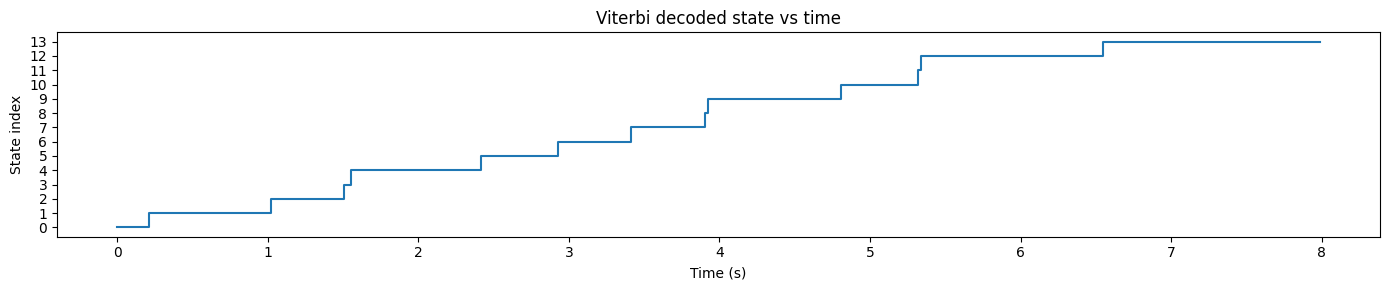

In [74]:
plot_state_path(path, sr, hop_length)

Here, we see that state switches are detected, but some switches happen too close to a previous switch. This is the classic symptom of “local ambiguity”: emissions don’t strongly prefer the current state over the next (or vice versa), so Viterbi is happy to do rapid 1–2 frame “blips” to the next state and back (or it advances too soon).

### Fix attempt 1: state expansion + softmax layer
The first attempt we will take to fix this is to use a viterbi algorithm with cooldown mechanism, which is essentally a buffer to prevent/discourage state switches that are too close to previous switches.

In [83]:
def viterbi_left_right_cooldown(A, pi, B, min_gap=6, adv_penalty=0.0):
    """
    Enforce a minimum gap between advances by using a cooldown state.

    min_gap: minimum frames between advances (e.g., 6 frames ~ 140ms with hop=512,sr=22050)
    adv_penalty: extra log-penalty added to ADV transitions (use negative value to discourage)
    """
    S, T = B.shape
    logA  = np.where(A > 0, np.log(A), -np.inf)
    logpi = np.where(pi > 0, np.log(pi), -np.inf)

    G = min_gap + 1  

    dp = np.full((S, G, T), -np.inf)
    bp_s = np.zeros((S, G, T), dtype=int)
    bp_g = np.zeros((S, G, T), dtype=int)

    dp[:, :, 0] = -np.inf
    dp[0, min_gap, 0] = logpi[0] + B[0, 0]

    for t in range(1, T):
        for s in range(S):
            for g in range(G):
                g2 = min(min_gap, g + 1)
                stay_score = dp[s, g, t-1] + logA[s, s] + B[s, t]

                best_score = stay_score
                best_prev_s, best_prev_g = s, g

                if s > 0 and g == min_gap:
                    adv_score = dp[s-1, g, t-1] + logA[s-1, s] + adv_penalty + B[s, t]
                    if adv_score > best_score:
                        best_score = adv_score
                        best_prev_s, best_prev_g = s-1, g  # from previous state, cooldown satisfied

                    if best_prev_s == s-1 and best_score == adv_score:
                        dp[s, 0, t] = best_score
                        bp_s[s, 0, t] = best_prev_s
                        bp_g[s, 0, t] = best_prev_g
                        continue

                dp[s, g2, t] = best_score
                bp_s[s, g2, t] = best_prev_s
                bp_g[s, g2, t] = best_prev_g

    # pick best ending (any state, any cooldown)
    end_s, end_g = np.unravel_index(np.argmax(dp[:, :, -1]), dp[:, :, -1].shape)

    path = np.zeros(T, dtype=int)
    path[-1] = end_s
    g = end_g
    s = end_s

    for t in range(T-1, 0, -1):
        ps = bp_s[s, g, t]
        pg = bp_g[s, g, t]
        path[t-1] = ps
        s, g = ps, pg

    return path

/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/3928182969.py:9: RuntimeWarning: divide by zero encountered in log
  logA  = np.where(A > 0, np.log(A), -np.inf)
/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/3928182969.py:10: RuntimeWarning: divide by zero encountered in log
  logpi = np.where(pi > 0, np.log(pi), -np.inf)


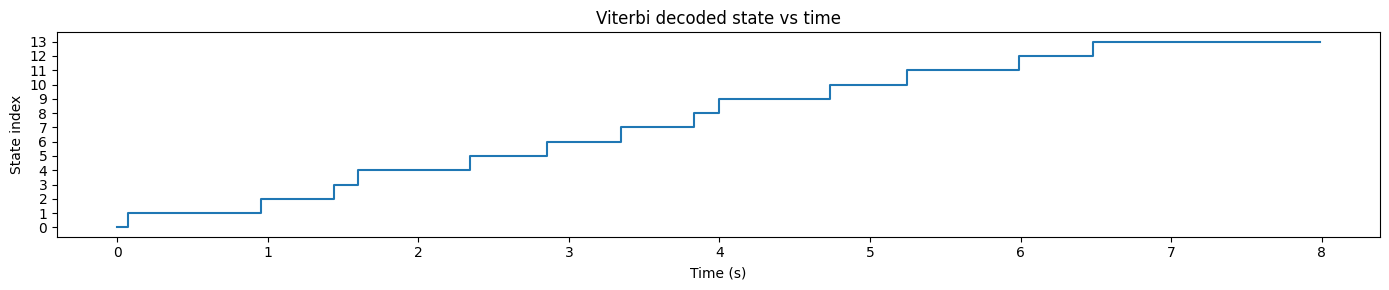

In [84]:
path2 = viterbi_left_right_cooldown(A, pi, B, min_gap=6, adv_penalty=0.0)
plot_state_path(path2, sr, hop_length)

We will also try and do a softmax to make scores log probabilities

In [77]:
def emissions_softmax_from_scores(scores, temp=0.2, eps=1e-12):
    z = scores / temp
    z = z - z.max(axis=0, keepdims=True)
    P = np.exp(z)
    P /= (P.sum(axis=0, keepdims=True) + eps)
    return np.log(P + eps)

/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/63886501.py:9: RuntimeWarning: divide by zero encountered in log
  logA  = np.where(A > 0, np.log(A), -np.inf)
/var/folders/_g/r_5kzcvn6f59ld2yfw2jrl2w0000gn/T/ipykernel_35354/63886501.py:10: RuntimeWarning: divide by zero encountered in log
  logpi = np.where(pi > 0, np.log(pi), -np.inf)


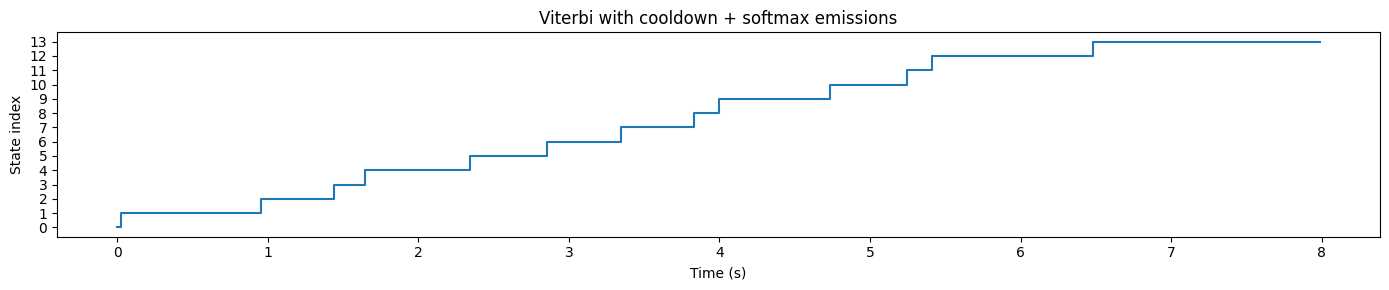

In [80]:
B2 = emissions_softmax_from_scores(scores, temp=0.25)
path3 = viterbi_left_right_cooldown(A, pi, B2, min_gap=6)
plot_state_path(path3, sr, hop_length, title="Viterbi with cooldown + softmax emissions")

### Fix attempt 2: factor in onset strength from the chroma spectogram into the viterbi algorithm

In [97]:
def onset_env(y, sr, hop_length, T):
    onset = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    # normalize to [0,1]
    onset = (onset - onset.min()) / (onset.max() - onset.min() + 1e-9)
    # align length
    if len(onset) < T:
        onset = np.pad(onset, (0, T-len(onset)), mode="edge")
    else:
        onset = onset[:T]
    return onset

def sharpen_onset(onset, power=2.0, smooth=3):
    o = onset.copy()
    if smooth and smooth > 1:
        k = smooth
        o = np.convolve(o, np.ones(k)/k, mode="same")
    o = np.clip(o, 0, 1)
    o = o ** power   # emphasize peaks
    return o

def viterbi_left_right_onset(A, pi, B, onset, gamma=3.0, beta=1.5, eps=1e-12):

    S, T = B.shape
    logA  = np.where(A > 0, np.log(A + eps), -np.inf)
    logpi = np.where(pi > 0, np.log(pi + eps), -np.inf)

    dp = np.full((S, T), -np.inf)
    bp = np.zeros((S, T), dtype=int)

    dp[:, 0] = logpi + B[:, 0]

    for t in range(1, T):
        o = float(onset[t])

        for s in range(S):
            # stay
            stay = dp[s, t-1] + logA[s, s]

            # advance from s-1 -> s with onset gating
            if s > 0:
                adv = dp[s-1, t-1] + logA[s-1, s]
                adv += gamma * o - beta * (1.0 - o)
            else:
                adv = -np.inf

            if adv > stay:
                dp[s, t] = adv + B[s, t]
                bp[s, t] = s-1
            else:
                dp[s, t] = stay + B[s, t]
                bp[s, t] = s

    path = np.zeros(T, dtype=int)
    path[-1] = int(np.argmax(dp[:, -1]))
    for t in range(T-2, -1, -1):
        path[t] = bp[path[t+1], t+1]

    return path, dp

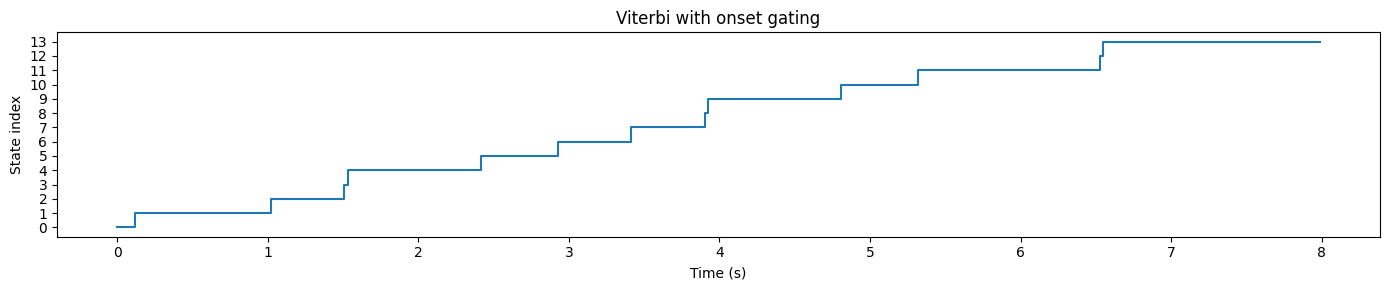

In [100]:
T = C.shape[1]
onset = onset_env(y, sr, hop_length=512, T=T)
onset = sharpen_onset(onset, power=2.0, smooth=5)
path, dp = viterbi_left_right_onset(A, pi, B, onset, gamma=3.0, beta=1.5)
plot_state_path(path, sr, hop_length, title="Viterbi with onset gating")

We realize that the double state switches are happenening when the same note is expected twice.